W pierwszym kroku należy załadować obraz, zmienić go na grayscale, znormalizować a potem zapisac do macierzy żeby zaczać wykonywać na nim operacje.

In [48]:
from PIL import Image
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

def loadImage(src):
    try:
        image = Image.open(src).convert("L")
    except IOError:
        print(f"Could not find file: {src}")
        return
    imgMatrix = np.asarray(image)
    # plotting for debug purpouses
    plt.matshow(imgMatrix, cmap=plt.cm.gray)
    plt.show()
    
    return imgMatrix

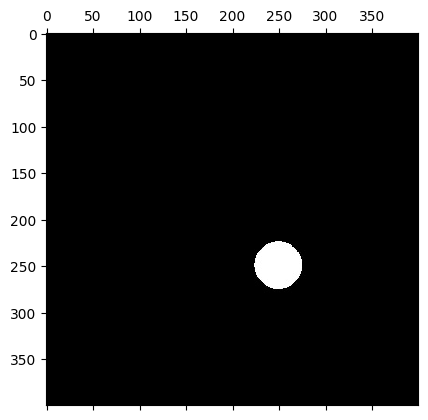

In [49]:
imgMatrix = loadImage("img/Kropka.jpg")

Następny etap to sinogram.
W następnym bloku będą też ustalane stałe detektorów.

In [50]:
alpha = 2
phi_range = 90
num_detectors = 180
num_iterations = 90

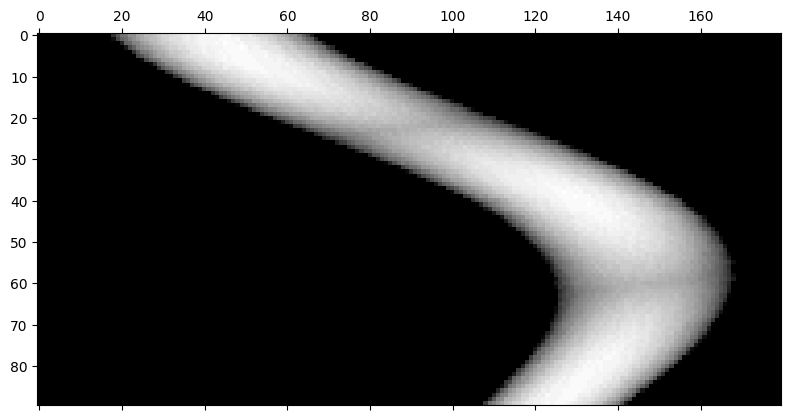

In [51]:
import numpy as np
from skimage.draw import line_nd

def avg_brightness(line, image = imgMatrix):
    height, width = image.shape
    sum = 0
    line = list(zip(line[0], line[1]))
    for [y, x] in line:
        if (x < 0 or x >= height) or (y < 0 or y >= width):
            continue
        sum += image[x,y]
    return int(sum / 255)

def radon_transform(alpha = 2, phi_range = 90, num_detectors = 180, num_iterations = 90, image = imgMatrix):
    height, width = image.shape
    radius = int(np.sqrt(height**2 + width**2) // 2)
    x_offset = width // 2
    y_offset = height // 2
    phi_rad = np.radians(phi_range)
    
    sinogram = np.asarray([[0 for i in range(num_detectors)] for j in range(num_iterations)])
    
    for i in range(num_iterations):
        curr_alpha = i * np.radians(alpha)
        xe = int(radius * np.cos(curr_alpha)) + x_offset
        ye = int(radius * np.sin(curr_alpha)) + y_offset
        
        for j in range(num_detectors):
            xd = int(radius * np.cos(curr_alpha + np.pi - (phi_rad / 2) + j * phi_rad/(num_detectors-1))) + x_offset
            yd = int(radius * np.sin(curr_alpha + np.pi - (phi_rad / 2) + j * phi_rad/(num_detectors-1))) + y_offset
            sinogram[i][j] = avg_brightness(line_nd([xe,ye],[xd,yd]), imgMatrix)
    return sinogram
    
whole_sinogram = radon_transform()
plt.matshow(sinogram, cmap=plt.cm.gray)
plt.show()

Poszczególne iteracje transformaty.

In [60]:
import ipywidgets as widgets
from IPython.display import display, clear_output

int_range_sinogram = widgets.IntSlider(min=1, max=num_iterations)
output1 = widgets.Output()
display(int_range_sinogram, output1)

def on_value_change_sinogram(change):
    with output1:
        sinogram = radon_transform(num_iterations=change['new'])
        clear_output(wait=True)
        print(change["new"])
        plt.matshow(sinogram, cmap=plt.cm.gray)
        plt.show()

int_range.observe(on_value_change_sinogram, names='value')

IntSlider(value=4, max=90, min=1)

Output()

Rekonstrukcja obrazu (backprojection).

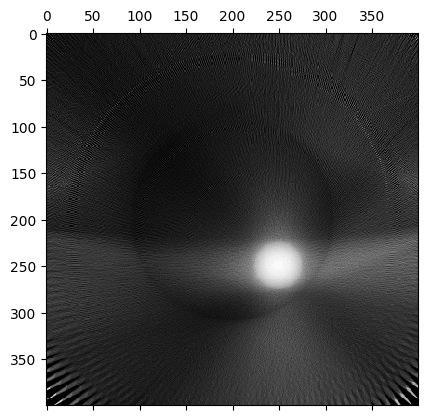

In [85]:
from sklearn.preprocessing import normalize
import copy

def draw_line(line, image, i, j, pixel_counter, sinogram):
    height, width = image.shape
    line = list(zip(line[0], line[1]))
    for [y, x] in line:
        if (x < 0 or x >= height) or (y < 0 or y >= width):
            continue
        image[x,y] += sinogram[i][j]
        pixel_counter[x,y] += 1
    return image

def backprojection(alpha = 2, phi_range = 90, num_detectors = 180, num_iterations = 90, image = imgMatrix, sinogram = whole_sinogram):
    height, width = image.shape
    radius = int(np.sqrt(height**2 + width**2) // 2)
    x_offset = width // 2
    y_offset = height // 2
    phi_rad = np.radians(phi_range)

    reconstruction = np.asarray([[0 for i in range(imgMatrix.shape[0])] for j in range(imgMatrix.shape[1])])
    pixel_counter = np.asarray([[1 for i in range(imgMatrix.shape[0])] for j in range(imgMatrix.shape[1])])
    
    for i in range(num_iterations):
        curr_alpha = i * np.radians(alpha)
        xe = int(radius * np.cos(curr_alpha)) + x_offset
        ye = int(radius * np.sin(curr_alpha)) + y_offset
        
        for j in range(num_detectors):
            xd = int(radius * np.cos(curr_alpha + np.pi - (phi_rad / 2) + j * phi_rad/(num_detectors-1))) + x_offset
            yd = int(radius * np.sin(curr_alpha + np.pi - (phi_rad / 2) + j * phi_rad/(num_detectors-1))) + y_offset
            reconstruction = draw_line(line_nd([xe,ye],[xd,yd]), reconstruction, i, j, pixel_counter, sinogram)
    
    for y, x in np.ndindex(reconstruction.shape):
        reconstruction[x][y] = reconstruction[x][y] / pixel_counter[x][y]
    return reconstruction

whole_reconstruction = backprojection()
plt.matshow(whole_reconstruction, cmap=plt.cm.gray)
plt.show()

In [83]:
import ipywidgets as widgets
from IPython.display import display, clear_output

int_range_backprojection = widgets.IntSlider(min=1, max=num_iterations)
output2 = widgets.Output()
display(int_range_backprojection, output2)

def on_value_change_backprojection(change):
    with output2:
        recounstruction = backprojection(num_iterations=change['new'])
        clear_output(wait=True)
        plt.matshow(recounstruction, cmap=plt.cm.gray)
        plt.show()

int_range_backprojection.observe(on_value_change_backprojection, names='value')

IntSlider(value=1, max=90, min=1)

Output()

Zapis do pliku dicom.

In [107]:
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img = convert_image_to_ubyte(img)
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img.tobytes()

    ds.save_as(file_name, write_like_original=False)

patient_data = {"PatientName": "Sebastian",
               "PatientID": "123",
               "ImageComments": "lorem ipsum"}

save_as_dicom("img-dicom/xyz.dcm", whole_reconstruction, patient_data)

Odczytywanie pliku dicom.


File path........: img-dicom/xyz.dcm
SOP Class........: 1.2.840.10008.5.1.4.1.1.2 (CT Image Storage)

Patient's Name...: Sebastian, 
Patient ID.......: 123
Modality.........: CT
Image size.......: 400 x 400


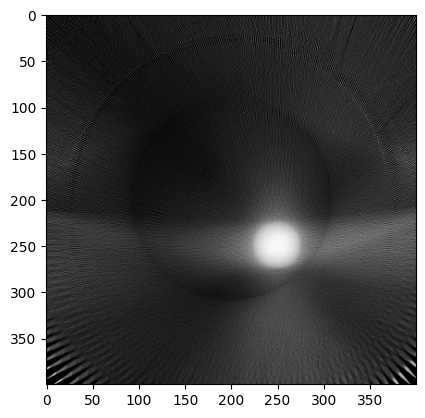

In [108]:
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file

ds = dcmread("img-dicom/xyz.dcm", force=True)

# Normal mode:
print()
print(f"File path........: {path}")
print(f"SOP Class........: {ds.SOPClassUID} ({ds.SOPClassUID.name})")
print()

pat_name = ds.PatientName
print(f"Patient's Name...: {pat_name.family_comma_given()}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Modality.........: {ds.Modality}")
#print(f"Study Date.......: {ds.StudyDate}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
#print(f"Pixel Spacing....: {ds.PixelSpacing}")

# use .get() if not sure the item exists, and want a default value if missing

# plot the image using matplotlib
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()